In [1]:
import pandas as pd
from PIL import Image
from datasets import Dataset, DatasetDict, concatenate_datasets, load_from_disk
import os
import zipfile
import requests
from transformers import ViltConfig
import torch
import io

In [2]:
config = ViltConfig.from_pretrained("vilt-Med_RAD-finetuned-vqa-KHC-4-with_valid_labels")

In [3]:
config.label2id

{'0': 82,
 '000': 3001,
 '1': 12,
 '1 4': 1990,
 '1 foot': 335,
 '1 hour': 1967,
 '1 in back': 3026,
 '1 in front': 2299,
 '1 in middle': 3059,
 '1 inch': 2146,
 '1 on left': 1723,
 '1 on right': 314,
 '1 way': 201,
 '1 world': 2360,
 '1 year': 2807,
 '1. acute subdural hematomas (bilateral convexities, interhemispheric, tentorial leaf) 2. transtentorial herniation 3. traumatic subarachnoid hemorrhage.': 4458,
 "1. bennett's fracture 2. multiple growth arrest lines": 3645,
 '1. mid-substance acl tear. 2. lateral capsular avulsion consistent with segond fracture': 3256,
 '1.00': 3000,
 '10': 103,
 '10 feet': 941,
 '10 inches': 2929,
 '10 years': 47,
 '10-20 minutes': 5038,
 '100': 1161,
 '100 feet': 150,
 '100 year party ct': 3120,
 '1000': 1511,
 '101': 2789,
 '106': 2450,
 '10:00': 1661,
 '10:05': 1184,
 '10:08': 3117,
 '10:10': 519,
 '10:15': 2766,
 '10:20': 2177,
 '10:25': 2048,
 '10:30': 2410,
 '10:35': 3103,
 '10:40': 2040,
 '10:45': 3060,
 '10:50': 2880,
 '10:55': 2451,
 '11': 19

In [4]:
# load data set combined_datasets
train= load_from_disk('./combined_datasets/train')
validation= load_from_disk('./combined_datasets/validation')

combined_datasets= DatasetDict({'train': train, 'validation': validation})
combined_datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer', 'label'],
        num_rows: 14585
    })
    validation: Dataset({
        features: ['image', 'question', 'answer', 'label'],
        num_rows: 2451
    })
})

In [5]:
class VQADataset(torch.utils.data.Dataset):
    """VQA dataset."""

    def __init__(self, dataset, processor, id2label):
        self.dataset = dataset
        self.processor = processor
        self.id2label = id2label

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get image, question, and label
        data = self.dataset[idx]
        #image_path = data['image_path']
        question = data['question']
        label = data['label']

        # Open image
        #image = Image.open(image_path)#.convert('RGB')
        image = data['image']
        
        # Process image and question
        encoding = self.processor(image, question, padding="max_length", truncation=True, return_tensors="pt")
        
        # Remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        # Create target tensor
        targets = torch.zeros(len(self.id2label))
        targets[label] = 1  # Set the label index to 1

        encoding["labels"] = targets

        return encoding

In [6]:

from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

train_dataset = VQADataset(dataset=combined_datasets['train'], processor=processor, id2label=config.id2label)
validation_dataset = VQADataset(dataset=combined_datasets['validation'], processor=processor, id2label=config.id2label)


In [7]:
len(train_dataset), len(validation_dataset)

(14585, 2451)

In [8]:
train_dataset[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [9]:
processor.decode(train_dataset[0]['input_ids'])

'[CLS] what kind of image is this? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [10]:
labels = torch.nonzero(train_dataset[0]['labels']).squeeze().tolist()

config.id2label[labels]

'cta - ct angiography'

In [11]:
train_dataset[0]['pixel_values']

tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1

In [12]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [13]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, collate_fn=collate_fn, batch_size=4, shuffle=False)

In [14]:
len(train_dataloader), len(validation_dataloader)

(3647, 613)

In [15]:
batch = next(iter(train_dataloader))

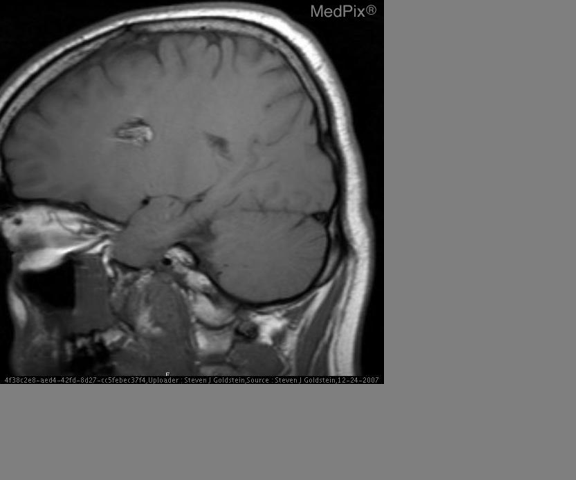

In [16]:
from PIL import Image
import numpy as np

image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [17]:
processor.decode(batch["input_ids"][batch_idx])

'[CLS] is this a contrast or noncontrast mri? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [18]:
labels = torch.nonzero(batch['labels'][batch_idx]).squeeze().tolist()

In [19]:
config.id2label[labels] 

'noncontrast'

In [20]:
import torch
from tqdm.notebook import tqdm
import os

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Define the directory to save checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the save step (e.g., save every 200 steps)
save_steps = 1000
global_step = 0

# Define early stopping criteria
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Define the function to save the checkpoint
def save_checkpoint(model, optimizer, epoch, step, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint-epoch-{epoch}-step-{step}.pt")
    torch.save({
        'epoch': epoch,
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

# Function to evaluate the model on the validation set
def evaluate(model, validation_dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in validation_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
    avg_loss = total_loss / len(validation_dataloader)
    model.train()  # Set the model back to training mode
    return avg_loss

# Training loop
Loss_list = []
val_loss_list = []
val_loss_list_epochs = [0]
val_loss_list.append(evaluate(model, validation_dataloader))
model.train()
for epoch in range(50):  # loop over the dataset multiple times
    print(f"Epoch: {epoch}")
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        Loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

        # Increment global step
        global_step += 1

        # Save the model at save_steps intervals
        if global_step % save_steps == 0:
            #save_checkpoint(model, optimizer, epoch, global_step, checkpoint_dir)
            val_loss_list.append(evaluate(model, validation_dataloader))
            val_loss_list_epochs.append(global_step/len(train_dataloader))


    # Evaluate the model on the validation set at the end of each epoch
    val_loss = evaluate(model, validation_dataloader)
    print(f"Validation Loss: {val_loss}")
    val_loss_list.append(val_loss)
    val_loss_list_epochs.append(global_step/len(train_dataloader))

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model
        save_checkpoint(model, optimizer, epoch, global_step, checkpoint_dir)
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break


Epoch: 0


  0%|          | 0/3647 [00:00<?, ?it/s]

Loss: 3845.839111328125
Loss: 3740.665771484375
Loss: 3637.50634765625
Loss: 3553.086669921875
Loss: 3446.74658203125
Loss: 3358.802734375
Loss: 3273.98486328125
Loss: 3174.095458984375
Loss: 3080.91357421875
Loss: 2996.039794921875
Loss: 2924.114990234375
Loss: 2829.220947265625
Loss: 2743.862548828125
Loss: 2664.88720703125
Loss: 2575.5126953125
Loss: 2486.951171875
Loss: 2403.985595703125
Loss: 2327.369384765625
Loss: 2257.389892578125
Loss: 2176.56494140625
Loss: 2100.683349609375
Loss: 2036.9342041015625
Loss: 1964.92431640625
Loss: 1895.700439453125
Loss: 1832.78857421875
Loss: 1774.0850830078125
Loss: 1713.9432373046875
Loss: 1652.879638671875
Loss: 1596.8555908203125
Loss: 1545.927001953125
Loss: 1497.9725341796875
Loss: 1443.95361328125
Loss: 1396.395263671875
Loss: 1350.270751953125
Loss: 1305.4525146484375
Loss: 1262.273193359375
Loss: 1220.813232421875
Loss: 1181.4798583984375
Loss: 1144.6490478515625
Loss: 1107.458251953125
Loss: 1074.2342529296875
Loss: 1037.7039794921875

  0%|          | 0/3647 [00:00<?, ?it/s]

Loss: 2.0768165588378906
Loss: 4.0804619789123535
Loss: 4.217167854309082
Loss: 4.009024620056152
Loss: 4.910437107086182
Loss: 2.5738813877105713
Loss: 4.509941577911377
Loss: 4.0147175788879395
Loss: 4.842471122741699
Loss: 3.4131643772125244
Loss: 6.021867275238037
Loss: 1.8142331838607788
Loss: 4.253854751586914
Loss: 5.947373390197754
Loss: 3.4906768798828125
Loss: 2.9350972175598145
Loss: 5.280022144317627
Loss: 3.983644723892212
Loss: 4.76467752456665
Loss: 6.7027082443237305
Loss: 4.33302116394043
Loss: 3.537393093109131
Loss: 1.9783388376235962
Loss: 2.3380379676818848
Loss: 5.934712886810303
Loss: 3.895641565322876
Loss: 5.107104301452637
Loss: 5.660679817199707
Loss: 4.645333766937256
Loss: 6.0867462158203125
Loss: 3.6599700450897217
Loss: 4.156297206878662
Loss: 6.836350440979004
Loss: 2.4341063499450684
Loss: 4.691946983337402
Loss: 4.973881721496582
Loss: 5.821800708770752
Loss: 5.394184589385986
Loss: 3.345979928970337
Loss: 3.4487998485565186
Loss: 5.864948749542236
Los

KeyboardInterrupt: 

In [21]:
# Save the Loss_list, devide by len(train_dataloader) for the x-axis to be in epochs
import pandas as pd

Loss_list_epochs = [i/len(train_dataloader) for i in range(len(Loss_list))]

df = pd.DataFrame(list(zip(Loss_list_epochs, Loss_list)), columns =['Epochs', 'Loss'])
df.to_csv('Loss_list.csv', index=False)

# Save the val_loss_list
df = pd.DataFrame(list(zip(val_loss_list_epochs, val_loss_list)), columns =['Epochs', 'Validation Loss'])
df.to_csv('val_loss_list.csv', index=False)

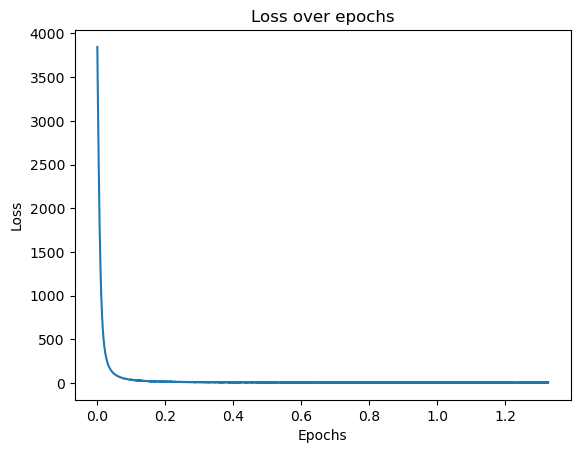

In [22]:
# Plot the loss and save it as a png
import matplotlib.pyplot as plt

plt.plot(Loss_list_epochs, Loss_list, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.savefig('Loss_over_epochs.png')

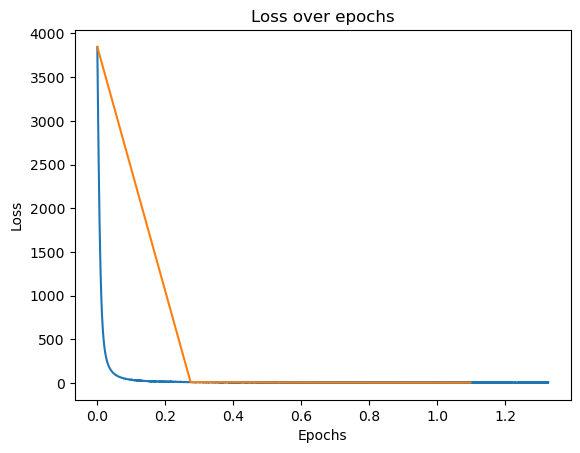

In [23]:
# Plot the loss and save it as a png
import matplotlib.pyplot as plt

plt.plot(Loss_list_epochs, Loss_list, label='Train Loss')
plt.plot(val_loss_list_epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.savefig('Loss_train_and_validation_over_epochs.png')

In [24]:
# save model in local directory
model.save_pretrained("./vilt-Med_RAD-finetuned-vqa-KHC-config-extend")

In [64]:
# test on sample picked validation dataset

import random

# Pick a random sample from the validation dataset
sample = random.choice(validation_dataset)
sample

{'input_ids': tensor([  101,  2054, 16913, 23732,  2001,  2109,  2000,  2202,  2023,  3746,
         1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-0.8824, -0.8745, -0.8745,  ...,  0.5608,  0.5686,  0.5686],
         [-0.8667, -0.8667, -0.8588,  ...,  0.5608,  0.5608,  0.5686],
         [-0.8824, -0.8745, -0.8745,  ...,  0.5608,  0.5608,  0.5608],
         ...,
         [-0.9922, -0.9922, -0.9922,  ..., -0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922,  ..., -0.

In [65]:
# Process the sample
sample = {k: v.unsqueeze(0).to(device) for k, v in sample.items()}
outputs = model(**sample)

# Get the predicted label
predicted_label = outputs.logits.argmax().item()
predicted_answer = config.id2label[predicted_label]
predicted_answer


'xr - plain film'

In [66]:
# Get the ground truth question image und answer
question = processor.decode(sample['input_ids'].squeeze())
question

'[CLS] what modality was used to take this image? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [67]:
answer = config.id2label[torch.nonzero(sample['labels'].squeeze()).item()]
answer

'be - barium enema'

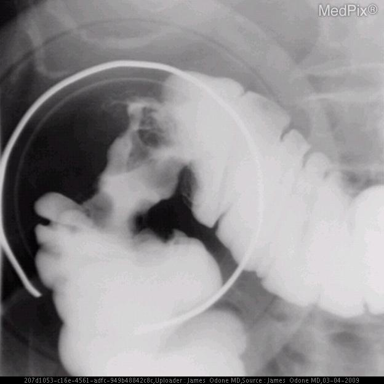

In [68]:
unnormalized_image = (sample['pixel_values'].squeeze().cpu().numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [21]:
""" from tqdm.notebook import tqdm


# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Define the directory to save checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the save step (e.g., save every 200 steps)
save_steps = 200
global_step = 0

# Define the function to save the checkpoint
def save_checkpoint(model, optimizer, epoch, step, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint-epoch-{epoch}-step-{step}.pt")
    torch.save({
        'epoch': epoch,
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

# Training loop
model.train()
for epoch in range(50):  # loop over the dataset multiple times
    print(f"Epoch: {epoch}")
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

        # Increment global step
        global_step += 1

        # Save the model at save_steps intervals
        if global_step % save_steps == 0:
            save_checkpoint(model, optimizer, epoch, global_step, checkpoint_dir)

    # Save the model at the end of each epoch
    save_checkpoint(model, optimizer, epoch, global_step, checkpoint_dir)
 """

' from tqdm.notebook import tqdm\n\n\n# Define the optimizer\noptimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)\n\n# Define the directory to save checkpoints\ncheckpoint_dir = "./checkpoints"\nos.makedirs(checkpoint_dir, exist_ok=True)\n\n# Define the save step (e.g., save every 200 steps)\nsave_steps = 200\nglobal_step = 0\n\n# Define the function to save the checkpoint\ndef save_checkpoint(model, optimizer, epoch, step, checkpoint_dir):\n    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint-epoch-{epoch}-step-{step}.pt")\n    torch.save({\n        \'epoch\': epoch,\n        \'step\': step,\n        \'model_state_dict\': model.state_dict(),\n        \'optimizer_state_dict\': optimizer.state_dict()\n    }, checkpoint_path)\n    print(f"Checkpoint saved at {checkpoint_path}")\n\n# Training loop\nmodel.train()\nfor epoch in range(50):  # loop over the dataset multiple times\n    print(f"Epoch: {epoch}")\n    for batch in tqdm(train_dataloader):\n        # get the input

In [22]:
""" from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(50):  # loop over the dataset multiple times
      print(f"Epoch: {epoch}")
      for batch in tqdm(train_dataloader):
            # get the inputs;
            batch = {k:v.to(device) for k,v in batch.items()}

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(**batch)
            loss = outputs.loss
            print("Loss:", loss.item())
            loss.backward()
            optimizer.step() """

' from tqdm.notebook import tqdm\noptimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)\n\nmodel.train()\nfor epoch in range(50):  # loop over the dataset multiple times\n      print(f"Epoch: {epoch}")\n      for batch in tqdm(train_dataloader):\n            # get the inputs;\n            batch = {k:v.to(device) for k,v in batch.items()}\n\n            # zero the parameter gradients\n            optimizer.zero_grad()\n\n            # forward + backward + optimize\n            outputs = model(**batch)\n            loss = outputs.loss\n            print("Loss:", loss.item())\n            loss.backward()\n            optimizer.step() '